In [1]:
import torch
import pickle
import os
from PIL import Image
from torch.nn.functional import softmax
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from IPython.utils import io
torch.set_printoptions(sci_mode=False)

### Setup Models

In [2]:
target_feature = 'category'

In [3]:
import platform
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [4]:
os.chdir(f"{ROOT_PATH}/4_Assessor/Category_Assessor/DinoV2")
from helpers_pipeline import *
from helper_DinoV2_Embeddings import *
id2label = pickle.load(open(f"id2label_dicts/{target_feature}_id2label.pkl", "rb"))
label2id = {v: k for k, v in id2label.items()}
os.chdir(current_wd)

Using devices: DinoV2 device: cpu | SG2 device: mps | General device: mps


In [5]:
set_seed(42)
dino_device, sg2_device, device = set_device()

Using devices: DinoV2 device: cpu | SG2 device: mps | General device: mps


In [6]:
df, latents = load_latents(target_feature)
latents = latents.to(sg2_device)

# SG2-Ada Generator
G = setup_generator()
G = G.to(sg2_device)

# DinoV2 Model 
dino_processor, dino_model = setup_dinov2()
dino_model = dino_model.to(dino_device)

# Attribute Classifier Model
classifier_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Classifier/dinov2_{target_feature}_classifier_with_generated.pt"
classifier = load_classifier(classifier_path)
classifier = classifier.to(device)

In [7]:
# Freeeze all non-relevant model weights and set to eval mode
for param in G.parameters():
    param.requires_grad = False
G.eval()
for param in dino_model.parameters():
    param.requires_grad = False
dino_model.eval()
for param in classifier.parameters():
    param.requires_grad = False
classifier.eval();


In [8]:
# Print devoce for each model: 
print(f"Generator: {next(G.parameters()).device} | Requires Grad: {next(G.parameters()).requires_grad}")
print(f"DinoV2: {next(dino_model.parameters()).device} | Requires Grad: {next(dino_model.parameters()).requires_grad}")
print(f"Classifier: {next(classifier.parameters()).device} | Requires Grad: {next(classifier.parameters()).requires_grad}")

Generator: mps:0 | Requires Grad: False
DinoV2: cpu | Requires Grad: False
Classifier: mps:0 | Requires Grad: False


In [9]:
def plot_generated(img):
    img_out = (img.permute(0,2,3,1)*127.5 + 128).clamp(0,255).to(torch.uint8)
    img_out = Image.fromarray(img_out[0].cpu().numpy())
    return img_out

In [10]:
z = torch.randn(1,512, device = sg2_device)
img_gen = G(z, None)

### Find Latent to experiment on

,sku,category,latent_idx
2231,EV421C11Q-Q11,Jumper dress,10538


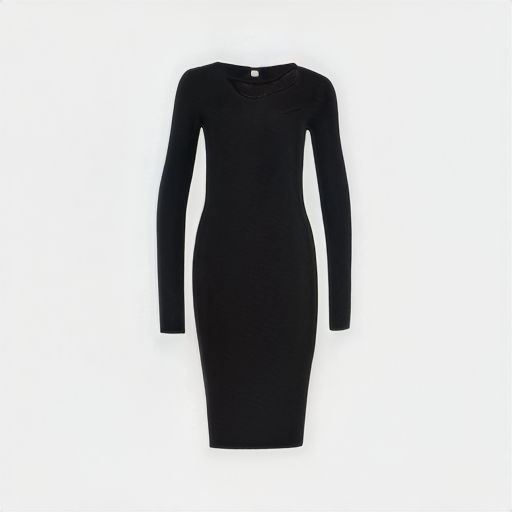

{'Day dress': 0.003528853179886937,
 'Jumper dress': 0.9372360110282898,
 'Jersey dress': 0.05581533536314964,
 'Cocktail dress / Party dress': 5.0497455106324196e-08,
 'Maxi dress': 0.003002109006047249,
 'Occasion wear': 2.806648922160093e-07,
 'Shift dress': 0.0004173892957624048,
 'Denim dress': 4.449570489839516e-09}

In [42]:
sample = df[df.category == 'Jumper dress'].sample(1) # 10538 is a good choice
sample = df[df.latent_idx == 10538]
display(sample)
img_gen = G.synthesis(latents[sample.latent_idx.item()].to(sg2_device), noise_mode='const') 
img_out = plot_generated(img_gen)
display(img_out)

# Forward pass through Assessor model
dino_input = dino_processor(img_gen).to(dino_device)
dino_embedding = dino_model(dino_input)['pooler_output'].to(device)
scores = classifier(dino_embedding)
scores = softmax(scores, dim=1)
scores_dict = {id2label[i]: score.item() for i, score in enumerate(scores.squeeze())}
scores_dict

### 1. Entangled Gradient Updated

Step 0 | Target Score: 0.48114120960235596, Target Prob: 0.003528853179886937 Gradient Norm: 4.429965019226074


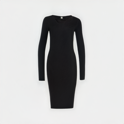

KeyboardInterrupt: 

In [50]:
# Forward pass through Assessor model
latent = latents[10538].cpu().numpy()
latent = torch.tensor(latent, requires_grad=True, device = sg2_device)

target_class_index = 0
learning_rate = 1
for i in range(100):
    img_gen = G.synthesis(latent, noise_mode='const')
    dino_input = dino_processor(img_gen).to(dino_device)
    dino_embedding = dino_model(dino_input)['pooler_output'].to(device)
    scores = classifier(dino_embedding)
    target_prob = scores[0, target_class_index]
    target_prob.backward()
    gradient = latent.grad  

    latent = latent + learning_rate * gradient
    latent = latent.detach()
    latent.requires_grad = True
    if i % 2 == 0:
        print(f"Step {i} | Target Score: {target_prob.item()}, Target Prob: {softmax(scores, dim =1)[0, target_class_index]} Gradient Norm: {gradient.norm().item()}")
        img_out = plot_generated(img_gen)
        display(img_out.resize((124,124)))

In [51]:
scores

tensor([[-3.7296, -0.5139,  0.9259, -3.1244,  0.5521,  2.1095, -5.5602, -8.9371]],
       device='mps:0', grad_fn=<LinearBackward0>)

In [61]:
latent = latents[10538].cpu().numpy()
latent = torch.tensor(latent, requires_grad=True, device = sg2_device)
img_gen = G.synthesis(latent, noise_mode='const')
dino_input = dino_processor(img_gen).to(dino_device)
dino_embedding = dino_model(dino_input)['pooler_output'].to(device)
scores = classifier(dino_embedding)

target_prob1 = scores[0, 0]
target_prob2 = scores[0, 1]

In [62]:
target_prob1, target_prob2

(tensor(0.4811, device='mps:0', grad_fn=<SelectBackward0>),
 tensor(6.0631, device='mps:0', grad_fn=<SelectBackward0>))

In [63]:
target_prob1.backward(retain_graph=True)
gradient1 = latent.grad

In [64]:
target_prob2.backward()
gradient2 = latent.grad

In [66]:
gradient1 == gradient2

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='mps:0')